# The Image Classification Dataset (Fashion-MNIST)

:label:`sec_fashion_mnist`


In :numref:`sec_naive_bayes`, we trained a naive Bayes classifier,
using the MNIST dataset introduced in 1998 :cite:`LeCun.Bottou.Bengio.ea.1998`. 
While MNIST had a good run as a benchmark dataset, 
even simple models by today's standards achieve classification accuracy over 95%.
making it unsuitable for distinguishing between stronger models and weaker ones. 
Today, MNIST serves as more of sanity checks than as a benchmark.
To up the ante just a bit, we will focus our discussion in the coming sections
on the qualitatively similar, but comparatively complex Fashion-MNIST 
dataset :cite:`Xiao.Rasul.Vollgraf.2017`, which was released in 2017.

In [1]:
%matplotlib inline
import d2l
from mxnet import gluon
import sys

d2l.use_svg_display()

## Getting the Dataset

Just as with MNIST, Gluon makes it easy to download and load the FashionMNIST dataset into memory via the `FashionMNIST` class contained in `gluon.data.vision`.
We briefly work through the mechanics of loading and exploring the dataset below. 
Please refer to :numref:`sec_naive_bayes` for more details on loading data.

In [2]:
mnist_train = gluon.data.vision.FashionMNIST(train=True)
mnist_test = gluon.data.vision.FashionMNIST(train=False)

FashionMNIST consists of images from 10 categories, each represented 
by 6k images in the training set and by 1k in the test set. 
Consequently the training set and the test set 
contain 60k and 10k images, respectively.

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

The images in Fashion-MNIST are associated with the following categories: 
t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag and ankle boot. 
The following function converts between numeric label indices and their names in text.

In [4]:
# Saved in the d2l package for later use
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

We can now create a function to visualize these examples.

In [5]:
# Saved in the d2l package for later use
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Here are the images and their corresponding labels (in text)
for the first few examples in the training dataset.

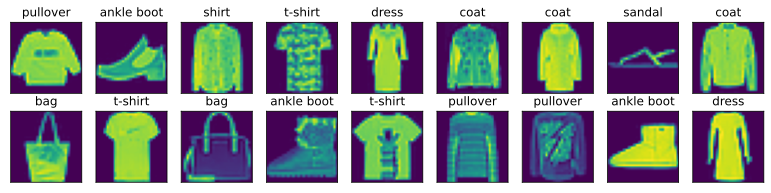

In [6]:
X, y = mnist_train[:18]
show_images(X.squeeze(axis=-1), 2, 9, titles=get_fashion_mnist_labels(y));

## Reading a Minibatch

To make our life easier when reading from the training and test sets,
we use a `DataLoader` rather than creating one from scratch, 
as we did in :numref:`sec_linear_scratch`. 
Recall that at each iteration, a `DataLoader` 
reads a minibatch of data with size `batch_size` each time.

During training, reading data can be a significant performance bottleneck, 
especially when our model is simple or when our computer is fast. 
A handy feature of Gluon's `DataLoader` is the ability 
to use multiple processes to speed up data reading.
For instance, we can set aside 4 processes to read the data (via `num_workers`).
Because this feature is not currently supported on Windows
the following code checks the platform to make sure
that we do not saddle our Windows-using friends 
with error messages later on.

In [7]:
# Saved in the d2l package for later use
def get_dataloader_workers(num_workers=4):
    # 0 means no additional process is used to speed up the reading of data.
    if sys.platform.startswith('win'):
        return 0
    else:
        return num_workers

Below, we convert the image data from uint8 to 32-bit 
floating point numbers using the `ToTensor` class.
Additionally, the transformer will divide all numbers by 255 
so that all pixels have values between 0 and 1. 
The `ToTensor` class also moves the image channel 
from the last dimension to the first dimension 
to facilitate the convolutional neural network calculations introduced later. 
Through the `transform_first` function of the dataset, 
we apply the transformation of `ToTensor` 
to the first element of each instance (image and label).

In [8]:
batch_size = 256
transformer = gluon.data.vision.transforms.ToTensor()
train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                   batch_size, shuffle=True,
                                   num_workers=get_dataloader_workers())

Let's look at the time it takes to read the training data.

In [9]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
'%.2f sec' % timer.stop()

'1.75 sec'

## Putting All Things Together 

Now we define the `load_data_fashion_mnist` function 
that obtains and reads the Fashion-MNIST dataset. 
It returns the data iterators for both the training set and validation set. 
In addition, it accepts an optional argument to resize images to another shape.

In [10]:
# Saved in the d2l package for later use
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load into memory."""
    dataset = gluon.data.vision
    trans = [dataset.transforms.Resize(resize)] if resize else []
    trans.append(dataset.transforms.ToTensor())
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=get_dataloader_workers()))

Below, we verify that image resizing works.

In [11]:
train_iter, test_iter = load_data_fashion_mnist(32, (64, 64))
for X, y in train_iter:
    print(X.shape)
    break

(32, 1, 64, 64)


We are now ready to work with the FashionMNIST dataset in the sections that follow.

## Summary

* Fashion-MNIST is an apparel classification dataset consisting of images representing 10 categories. 
 * We will use this dataset in subsequent sections and chapters to evaluate various classification algorithms.
* We store the shape of each image with height $h$ width $w$ pixels as $h \times w$ or `(h, w)`.
* Data iterators are a key component for efficient performance. Rely on well-implemented iterators that exploit multi-threading to avoid slowing down your training loop.

## Exercises

1. Does reducing the `batch_size` (for instance, to 1) affect read performance?
1. For non-Windows users, try modifying `num_workers` to see how it affects read performance. Plot the performance against the number of works employed.
1. Use the MXNet documentation to see which other datasets are available in `mxnet.gluon.data.vision`.
1. Use the MXNet documentation to see which other transformations are available in `mxnet.gluon.data.vision.transforms`.

## [Discussions](https://discuss.mxnet.io/t/2335)

![](../img/qr_fashion-mnist.svg)